Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Creates your data.yaml file inside Google Drive automatically

yaml_content = """# data.yaml for your Ninja 250R part detector

# Path to your dataset root (this folder contains images/ and labels/)
path: /content/drive/MyDrive/ninja250_parts

# Relative paths from that root
train: images/train
val: images/train

# Class names (each one gets an integer ID starting from 0)
names:
  0: front_brake_caliper
  1: rear_brake_caliper
  2: front_disc
  3: rear_disc
  4: chain
  5: radiator
  6: front_sprocket_cover
  7: coolant_reservoir
  8: rear_sprocket
  9: headlight
  10: taillight
  11: clutch_lever
  12: brake_lever
  13: battery
  14: carburetor
  """

# Save it into your Drive
with open("/content/drive/MyDrive/ninja250_parts/data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ data.yaml created at /content/drive/MyDrive/ninja250_parts/data.yaml")

✅ data.yaml created at /content/drive/MyDrive/ninja250_parts/data.yaml


Import Yolo, a tool we will be using to format data into an easy training pack

In [ ]:
!pip -q install ultralytics==8.3.25

from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 878.7/878.7 kB 20.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


This next cell verifies the file directory is setup correctly, prompting the user if the structure is missing components

In [ ]:
import os, glob

BASE = "/content/drive/MyDrive/ninja250_parts"

required = [
    BASE,
    BASE + "/images/train",
    BASE + "/labels/train",
    BASE + "/data.yaml"
]

for p in required:
    print(p, "FOUND" if os.path.exists(p) else "MISSING")

# Count images vs labels
image_files = glob.glob(BASE + "/images/train/*.jpg") + glob.glob(BASE + "/images/train/*.jpeg") + glob.glob(BASE + "/images/train/*.png")
label_files = glob.glob(BASE + "/labels/train/*.txt")

img_names = {os.path.splitext(os.path.basename(f))[0] for f in image_files}
lbl_names = {os.path.splitext(os.path.basename(f))[0] for f in label_files}

missing_labels = sorted(list(img_names - lbl_names))
missing_images = sorted(list(lbl_names - img_names))

print(f"\nTotal images: {len(img_names)}")
print(f"Total labels: {len(lbl_names)}")
print("Images missing labels:", missing_labels[:10])
print("Labels with no image:", missing_images[:10])

/content/drive/MyDrive/ninja250_parts FOUND
/content/drive/MyDrive/ninja250_parts/images/train FOUND
/content/drive/MyDrive/ninja250_parts/labels/train FOUND
/content/drive/MyDrive/ninja250_parts/data.yaml FOUND

Total images: 486
Total labels: 486
Images missing labels: []
Labels with no image: []


Time to train the model. The resulting weights (our custom model) will be stored within the file structure.

In [ ]:
DATA_YAML = "/content/drive/MyDrive/ninja250_parts/data.yaml"

# Load a small pretrained YOLOv8 model (nano = fast to train)
model = YOLO('yolov8n.pt')

results = model.train(
    data=DATA_YAML,                              # points to data.yaml
    epochs=60,                                   # you can bump to 100+ later
    imgsz=768,                                   # higher than 640 helps with small parts
    batch=16,                                    # drop to 8 or 4 if you OOM
    workers=2,                                   # 2 is fine/stable in Colab
    device=0,                                    # 0 = GPU
    project="/content/drive/MyDrive/ninja250_parts",
    name="yolov8n_parts",
    pretrained=True,
    cos_lr=True,
    patience=15,                                 # stop early if no val improvement
)

print("Training complete.")

New https://pypi.org/project/ultralytics/8.3.222 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.25 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/ninja250_parts/data.yaml, epochs=60, time=None, patience=15, batch=16, imgsz=768, save=True, save_period=-1, cache=False, device=0, workers=2, project=/content/drive/MyDrive/ninja250_parts, name=yolov8n_parts2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=Non

train: Scanning /content/drive/MyDrive/ninja250_parts/labels/train.cache... 486 images, 0 backgrounds, 0 corrupt: 100%|██████████| 486/486 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/ninja250_parts/labels/train.cache... 486 images, 0 backgrounds, 0 corrupt: 100%|██████████| 486/486 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/ninja250_parts/yolov8n_parts2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 768 train, 768 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/ninja250_parts/yolov8n_parts2
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.13G      2.087      4.659      2.199         29        768: 100%|██████████| 31/31 [00:21<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all        486       1022     0.0539      0.122     0.0622     0.0304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.21G      1.862      4.198      2.009         27        768: 100%|██████████| 31/31 [00:18<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


                   all        486       1022    0.00678      0.591      0.137     0.0676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.23G      1.848      3.642      1.957         27        768: 100%|██████████| 31/31 [00:17<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


                   all        486       1022      0.428      0.253      0.249      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.11G      1.874      3.232      1.929         24        768: 100%|██████████| 31/31 [00:17<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


                   all        486       1022      0.431      0.317      0.321      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.24G      1.852      2.997      1.898         35        768: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]


                   all        486       1022      0.579      0.305      0.326      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.24G      1.763      2.746      1.841         25        768: 100%|██████████| 31/31 [00:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


                   all        486       1022      0.466      0.488      0.467      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.24G      1.701      2.546      1.771         27        768: 100%|██████████| 31/31 [00:17<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


                   all        486       1022      0.709       0.49      0.573       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.11G      1.723      2.461      1.771         26        768: 100%|██████████| 31/31 [00:18<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]


                   all        486       1022      0.667      0.598      0.655       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.25G      1.627      2.335      1.701         12        768: 100%|██████████| 31/31 [00:18<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]


                   all        486       1022      0.682      0.633      0.685      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.24G       1.67      2.201      1.694         19        768: 100%|██████████| 31/31 [00:16<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


                   all        486       1022      0.657      0.631      0.665      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.23G      1.627      2.148      1.699         23        768: 100%|██████████| 31/31 [00:17<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


                   all        486       1022      0.676      0.679      0.729      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.11G      1.579       2.14       1.66         12        768: 100%|██████████| 31/31 [00:18<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


                   all        486       1022      0.735      0.686      0.764      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.25G      1.561      2.066       1.62         12        768: 100%|██████████| 31/31 [00:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]


                   all        486       1022      0.753      0.744      0.784      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.22G       1.59      2.023      1.632         46        768: 100%|██████████| 31/31 [00:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


                   all        486       1022      0.786      0.766      0.827      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.21G      1.578      1.949      1.598         23        768: 100%|██████████| 31/31 [00:18<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


                   all        486       1022      0.768      0.771      0.816      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60       3.1G      1.509      1.904      1.588         13        768: 100%|██████████| 31/31 [00:18<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]


                   all        486       1022      0.741      0.805      0.813      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.21G      1.493      1.786      1.544         31        768: 100%|██████████| 31/31 [00:17<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.44it/s]


                   all        486       1022      0.785       0.81      0.844      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.23G      1.458      1.754       1.53         19        768: 100%|██████████| 31/31 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


                   all        486       1022       0.81      0.793      0.868      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60       3.2G      1.494      1.729      1.548         31        768: 100%|██████████| 31/31 [00:19<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]


                   all        486       1022      0.821      0.807      0.874      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60       3.1G      1.449      1.666      1.529         26        768: 100%|██████████| 31/31 [00:18<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.44it/s]

                   all        486       1022      0.829      0.812      0.874      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.21G      1.435      1.631      1.496         25        768: 100%|██████████| 31/31 [00:17<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


                   all        486       1022      0.853      0.824      0.889      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.21G      1.442      1.617      1.519         21        768: 100%|██████████| 31/31 [00:17<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


                   all        486       1022      0.844      0.822      0.894      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.21G      1.413      1.578      1.468         17        768: 100%|██████████| 31/31 [00:17<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]

                   all        486       1022      0.877      0.834       0.91      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60       3.1G      1.379      1.525       1.46         23        768: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


                   all        486       1022      0.852      0.858      0.899      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.23G      1.401      1.499      1.482         36        768: 100%|██████████| 31/31 [00:18<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


                   all        486       1022      0.846      0.867      0.909      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.25G      1.313      1.452      1.447         31        768: 100%|██████████| 31/31 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


                   all        486       1022      0.846      0.886      0.925      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.23G      1.344      1.425      1.428         21        768: 100%|██████████| 31/31 [00:17<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


                   all        486       1022      0.874      0.894      0.927      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60       3.1G      1.307      1.392      1.417         23        768: 100%|██████████| 31/31 [00:17<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


                   all        486       1022      0.873      0.873      0.924      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.21G      1.321      1.365      1.432         34        768: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.44it/s]


                   all        486       1022      0.897      0.892      0.937      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.24G      1.304      1.362      1.418         22        768: 100%|██████████| 31/31 [00:17<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.44it/s]


                   all        486       1022      0.907      0.901      0.948      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.21G      1.308      1.331      1.415         23        768: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


                   all        486       1022       0.91      0.901      0.953      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60       3.1G       1.24      1.259      1.362         17        768: 100%|██████████| 31/31 [00:18<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        486       1022      0.927      0.916      0.958      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60       3.1G      1.221      1.246      1.359         15        768: 100%|██████████| 31/31 [00:19<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


                   all        486       1022      0.923      0.911      0.958       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.22G      1.237      1.249      1.372         19        768: 100%|██████████| 31/31 [00:17<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


                   all        486       1022      0.906      0.943       0.96      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60       3.2G      1.234      1.222      1.341         28        768: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        486       1022       0.93      0.921      0.963      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60       3.1G      1.207      1.205      1.359         32        768: 100%|██████████| 31/31 [00:17<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

                   all        486       1022      0.901      0.942      0.961      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.24G      1.216      1.198      1.333         21        768: 100%|██████████| 31/31 [00:17<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.44it/s]

                   all        486       1022      0.944      0.931      0.972      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.22G      1.192      1.177      1.353         15        768: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

                   all        486       1022      0.941      0.939      0.972      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.23G      1.174      1.165      1.328         31        768: 100%|██████████| 31/31 [00:17<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


                   all        486       1022      0.954       0.93      0.973      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60       3.1G      1.187      1.163       1.33         24        768: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


                   all        486       1022      0.941      0.943      0.971        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.22G      1.157       1.14      1.303         21        768: 100%|██████████| 31/31 [00:18<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


                   all        486       1022      0.942      0.944      0.974      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.21G      1.177      1.133      1.313         26        768: 100%|██████████| 31/31 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


                   all        486       1022      0.953      0.931      0.975      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.21G      1.154      1.129      1.312         27        768: 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


                   all        486       1022      0.957      0.953      0.979      0.723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60       3.1G      1.153      1.136      1.319         16        768: 100%|██████████| 31/31 [00:17<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

                   all        486       1022       0.95      0.953      0.978      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.23G      1.145      1.097      1.306         35        768: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

                   all        486       1022      0.946       0.95      0.977      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60       3.2G      1.112      1.072      1.278         18        768: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

                   all        486       1022      0.954      0.954      0.979      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60       3.2G      1.108      1.055      1.274         22        768: 100%|██████████| 31/31 [00:17<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]

                   all        486       1022      0.955      0.957      0.981      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60       3.1G      1.103      1.046      1.267         19        768: 100%|██████████| 31/31 [00:17<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        486       1022      0.961      0.954      0.982      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.22G      1.097      1.051      1.251         16        768: 100%|██████████| 31/31 [00:17<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

                   all        486       1022      0.956       0.96      0.982       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.22G      1.087      1.021      1.261         32        768: 100%|██████████| 31/31 [00:19<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


                   all        486       1022      0.959      0.962      0.983      0.746
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.19G      1.123      1.209      1.349          7        768: 100%|██████████| 31/31 [00:20<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all        486       1022      0.954      0.946      0.981      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.08G       1.09      1.152      1.302          8        768: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


                   all        486       1022      0.949      0.948      0.979      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.19G      1.085      1.133      1.288         14        768: 100%|██████████| 31/31 [00:16<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.44it/s]

                   all        486       1022      0.965      0.943      0.981      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60       3.2G      1.069        1.1      1.273         12        768: 100%|██████████| 31/31 [00:16<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]

                   all        486       1022      0.958      0.951      0.982      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.19G      1.041      1.084      1.269         18        768: 100%|██████████| 31/31 [00:17<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


                   all        486       1022      0.958      0.952      0.983      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.08G      1.028      1.093      1.267         10        768: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

                   all        486       1022       0.95      0.956      0.982      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.18G      1.025      1.055      1.263          8        768: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all        486       1022      0.957      0.952      0.983      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.19G      1.031      1.052      1.252         16        768: 100%|██████████| 31/31 [00:18<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

                   all        486       1022      0.957      0.952      0.983      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.19G          1      1.055      1.243         11        768: 100%|██████████| 31/31 [00:18<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


                   all        486       1022       0.96      0.952      0.983      0.746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.06G      1.034      1.071      1.262          9        768: 100%|██████████| 31/31 [00:18<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        486       1022      0.957      0.956      0.983      0.746



60 epochs completed in 0.502 hours.
Optimizer stripped from /content/drive/MyDrive/ninja250_parts/yolov8n_parts2/weights/last.pt, 6.3MB
Optimizer stripped from /content/drive/MyDrive/ninja250_parts/yolov8n_parts2/weights/best.pt, 6.3MB

Validating /content/drive/MyDrive/ninja250_parts/yolov8n_parts2/weights/best.pt...
Ultralytics 8.3.25 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


                   all        486       1022      0.957      0.956      0.983      0.746
   front_brake_caliper         51         51      0.979       0.98      0.993      0.708
    rear_brake_caliper         43         43      0.954      0.965      0.973      0.734
            front_disc         79         94      0.956      0.925      0.981      0.719
             rear_disc         52         54      0.946      0.972      0.989      0.743
                 chain        111        241      0.947      0.736      0.909      0.612
              radiator         30         30      0.985          1      0.995      0.851
  front_sprocket_cover         56         56      0.947          1      0.991      0.749
     coolant_reservoir         60         60      0.984      0.996      0.992      0.805
         rear_sprocket         43         43      0.955      0.953      0.992      0.772
             headlight         45         45      0.986          1      0.995      0.786
             tailligh

Validate model performance by running a validation test and checking the mAP and per-class metrics of the data.

In [ ]:
RUN_DIR = "/content/drive/MyDrive/ninja250_parts/yolov8n_parts2"
BEST_WEIGHTS = os.path.join(RUN_DIR, "weights", "best.pt")

model = YOLO(BEST_WEIGHTS)

metrics = model.val()  # evaluates on val set from data.yaml
print("Validation metrics:")
print(metrics.results_dict)

Ultralytics 8.3.25 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 24.3MB/s]
val: Scanning /content/drive/MyDrive/ninja250_parts/labels/train.cache... 486 images, 0 backgrounds, 0 corrupt: 100%|██████████| 486/486 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


                   all        486       1022      0.957      0.956      0.983      0.746
   front_brake_caliper         51         51      0.978       0.98      0.993      0.707
    rear_brake_caliper         43         43      0.954      0.965      0.973      0.735
            front_disc         79         94      0.956      0.925      0.981      0.719
             rear_disc         52         54      0.946      0.972      0.989      0.746
                 chain        111        241      0.946      0.733      0.909      0.613
              radiator         30         30      0.987          1      0.995      0.851
  front_sprocket_cover         56         56      0.946          1      0.991      0.751
     coolant_reservoir         60         60      0.984      0.996      0.992      0.807
         rear_sprocket         43         43      0.954      0.953      0.992      0.769
             headlight         45         45      0.985          1      0.995      0.786
             tailligh

Time to test it on a random image (perhaps a new image excluded from the training data).

Running prediction on: /content/drive/MyDrive/ninja250_parts/images/train/IMG_7031-compressed.jpg

image 1/1 /content/drive/MyDrive/ninja250_parts/images/train/IMG_7031-compressed.jpg: 576x768 1 rear_brake_caliper, 1 rear_disc, 1 chain, 8.4ms
Speed: 5.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 768)
Results saved to runs/detect/predict2


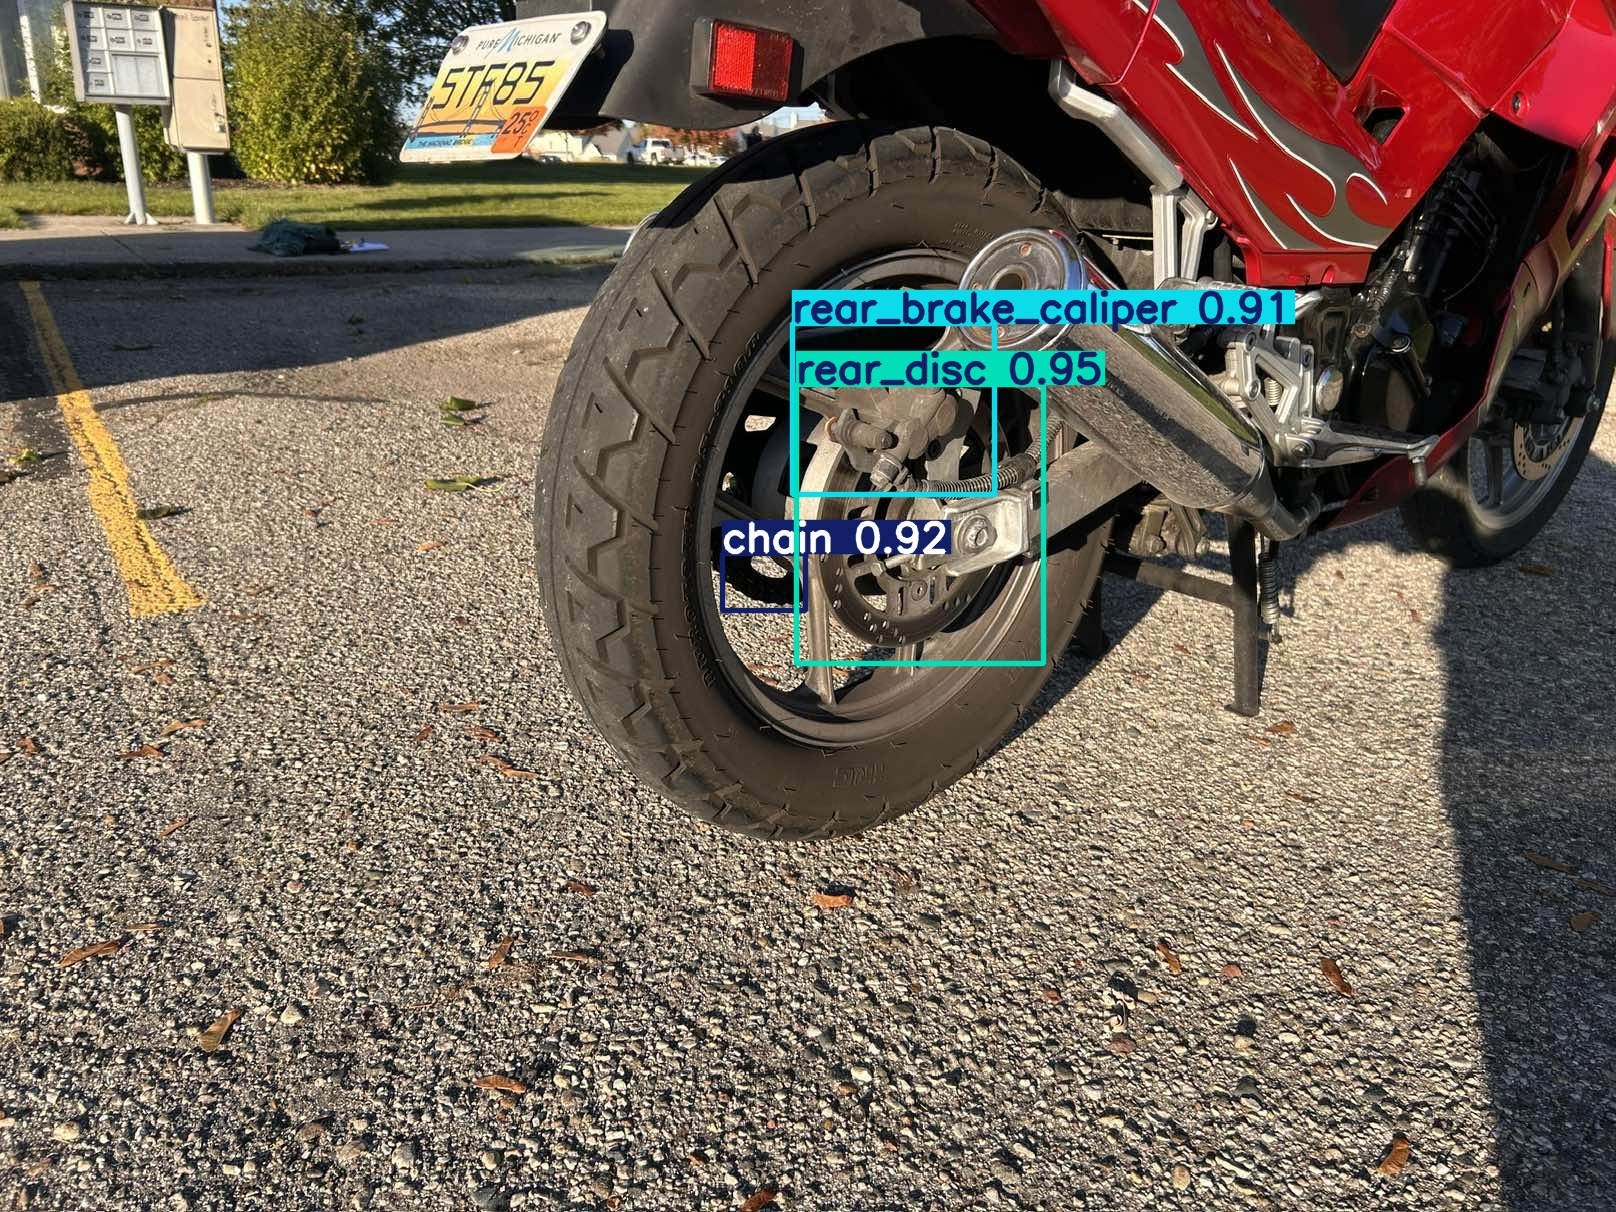

In [ ]:
from IPython.display import display, Image as IPyImage
import glob

BEST_WEIGHTS = "/content/drive/MyDrive/ninja250_parts/yolov8n_parts2/weights/best.pt"
model = YOLO(BEST_WEIGHTS)

# Pick one val image just to demo
some_val_images = glob.glob("/content/drive/MyDrive/ninja250_parts/images/train/IMG_7031-compressed.jpg")
if len(some_val_images) == 0:
    print("No val images yet.")
else:
    test_img = some_val_images[0] # insert test image here
    print("Running prediction on:", test_img)
    pred = model.predict(
        source=test_img,
        conf=0.25,
        save=True
    )

    # YOLO tells us where it saved the annotated image
    save_dir = pred[0].save_dir  # e.g. runs/detect/predictX
    annotated = list(glob.glob(os.path.join(save_dir, "*")))[0]
    display(IPyImage(filename=annotated))

Time to export the model for reuse if we decide to iterate further at a later date.

In [ ]:
BEST_WEIGHTS = "/content/drive/MyDrive/ninja250_parts/yolov8n_parts/weights/best.pt"
model = YOLO(BEST_WEIGHTS)

model.export(format="onnx", opset=12)        # onnx
model.export(format="torchscript")           # torchscript
# model.export(format="tflite")              # you can try later for mobile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!jupyter nbconvert --to html '/content/drive/MyDrive/Colab Notebooks/HNR499_NinjaPartIdentifyer_MacKellar'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/HNR499_NinjaPartIdentifyer_MacKellar to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 1755456 bytes to /content/drive/MyDrive/Colab Notebooks/HNR499_NinjaPartIdentifyer_MacKella.html
